In [1]:
import pandas as pd
import numpy as np

import os

from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics.pairwise import haversine_distances

import matplotlib.pyplot as plt
import seaborn as sns

import math
from math import radians
import datetime

from keplergl import KeplerGl
import geopandas as gpd

In [2]:
#['N139LB', N211LB', 'N234LB', N226LB', 'N228LB', N235LB', 'N238LB', 'N252LB', 'N271LB', 'N329LB', 'N789LB', 'N139LB', 'N166LB', 'N221LB', 
# 'N225LB']

raw_df = pd.DataFrame()

#target_loons = 
loon = ['N221LB']

for loon in target_loons:
    aux = pd.read_csv('../../../../og_data/' + loon + '.csv', parse_dates=['ts'], low_memory=False)
    
    raw_df = raw_df.append(aux)
    


In [3]:
bl = raw_df

In [4]:
# To determine eps we need the distance beetween traces
# Let's create a new column with the previous position of each trace

# First we order the data from oldest to newest
bl = bl.sort_values('ts')

bl['prev_lat'] = bl['lat'].shift()
bl['prev_lon'] = bl['lon'].shift()


In [5]:
# We must compute the haversine distance since the location units are coordinates of a sphere

def compute_haversine(dest_lat, dest_lon, og_lat, og_lon):
    
    # Convert to radians the locations
    r_dest_lat = radians(dest_lat)
    r_dest_lon = radians(dest_lon)

    r_og_lat = radians(og_lat)
    r_og_lon = radians(og_lon)

    # Compute haversine
    result = haversine_distances([[r_og_lat, r_og_lon], [r_dest_lat, r_dest_lon]])

    # Conversion from radians to Km uising the earth's radius.
    result = result * 6371000/1000

    return result[0][1]

# Compute the distance since last record using the above function
bl['distance_since_last_record'] = bl.apply(lambda x: compute_haversine(x.lat, x.lon, x.prev_lat, x.prev_lon),\
                                            axis=1)

bl['distance_since_last_record'] = bl['distance_since_last_record'].fillna(0)


bl['time_since_last_record'] = bl['ts'] - bl['ts'].shift()
bl['time_since_last_record'] = bl['time_since_last_record'].fillna(0)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.


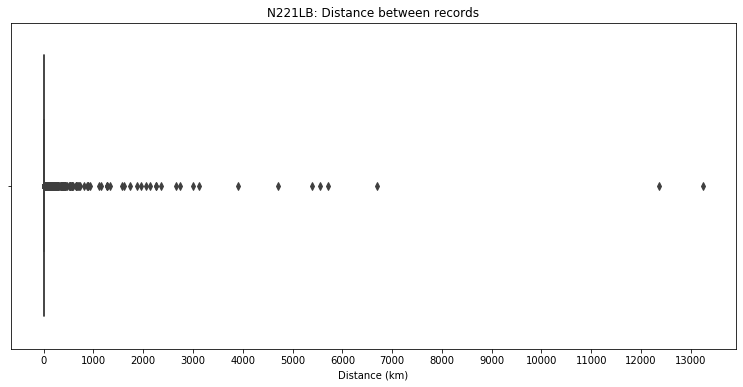

In [6]:
# Let's plot the distribution
plt.figure(figsize=(13,6))
plt.xticks(np.arange(min(bl.distance_since_last_record), max(bl.distance_since_last_record)+1, 1000))
    
ax = sns.boxplot(x=bl.distance_since_last_record)
dummy = ax.set_title(loon + ': Distance between records') 
dummy = ax.set_xlabel('Distance (km)')



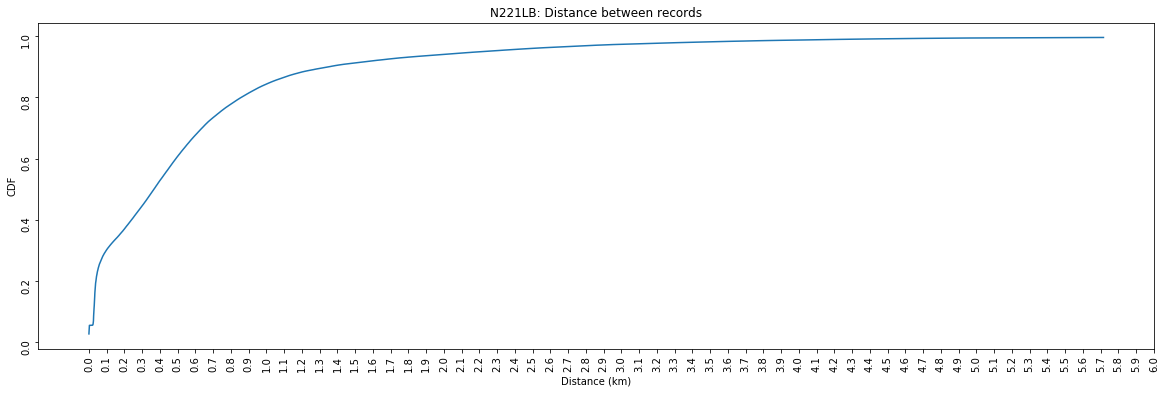

In [7]:
# Now we compute the cdf for distance_since_last_record
# We exclude the outliers to get a better glimpse of the data

quantile_99 = bl.distance_since_last_record.quantile(0.995)
x = bl.loc[bl.distance_since_last_record < quantile_99].sort_values('distance_since_last_record')\
                                                                            ['distance_since_last_record']

num_records_cdf = x.shape[0]
total_num_records = bl.shape[0]

idx_list = list(range(0, num_records_cdf, 1))
                
y = [x / total_num_records for x in idx_list]

plt.figure(figsize=(20,6))
plt.xticks(np.arange(min(x), max(x)+1, 0.1))

ax = sns.lineplot(x=x, y=y)

dummy = ax.set_ylabel('CDF')
dummy = ax.set_xlabel('Distance (km)')
dummy = ax.set_title(loon + ': Distance between records')
#dummy = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
dummy = ax.tick_params(labelsize=10, rotation=90)

In [10]:
#-------------------USER INPUT!!!-------------------

# Compute the range of distances to be used in DBSCAN
num_values = 20
start_distance = 0.1
end_distance = 20

step_size = (end_distance - start_distance) / (num_values-1)
max_distances = np.arange(start_distance, end_distance + step_size, step_size)

print(max_distances)



[ 0.1         1.14736842  2.19473684  3.24210526  4.28947368  5.33684211
  6.38421053  7.43157895  8.47894737  9.52631579 10.57368421 11.62105263
 12.66842105 13.71578947 14.76315789 15.81052632 16.85789474 17.90526316
 18.95263158 20.        ]


In [ ]:

# We need radians for the ball tree algorithm in DBSCAN
kms_per_radian = 6371.0088

# Compute the DBSCAN for each distance computed
for distance in max_distances:

    dbscan_bl = StandardScaler().fit_transform(bl[['lat', 'lon']])
    
    eps = distance / kms_per_radian
    
    # For now MinPts is set to 4
    db = DBSCAN(eps=eps, min_samples=4, algorithm='ball_tree', metric='haversine') \
            .fit(np.radians(dbscan_bl))
        
    print(str(loon) + ': ' + str(np.unique(db.labels_)) + '; eps=' + str(eps) \
            + '; max_distance= ' + str(distance))
    
    # Add the clustering info to the baseline
    bl['cluster'] = db.labels_
    bl['eps'] = eps
    bl['max_distance'] = distance
    
    # Save to file   
    bl.to_csv( '../../../../og_data/DBSCAN/epsRange/' + str(loon) \
                                  + '/CL-' + loon \
                                  + '-' + 'mp_4' + '-eps_' + str(eps) \
                                  + '.csv', index=False, encoding='utf-8-sig')
        

N221LB: [  -1    0    1 ... 2533 2534 2535]; eps=1.5696101377226163e-05; max_distance= 0.1
N221LB: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118]; eps=0.0001800921105387002; max_distance= 1.1473684210526316
N221LB: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]; eps=0.0003444881197001742; max_distance= 2.194736842105263
N221LB: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 2

In [ ]:
# Visualize the results

map = KeplerGl(height=700, width=800)#show -Rthe map
map

In [ ]:
# Create a geodataframe
bl_complete['time_since_last_record'] = bl_complete['time_since_last_record'].astype(str)
gdf = gpd.GeoDataFrame(bl_complete, geometry=gpd.points_from_xy(bl_complete.lon, bl_complete.lat))

map.add_data(data=gdf, name="loon traces")